In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from logistic_regression import LogisticRegression
from softmax_regression import SoftmaxRegression
%matplotlib inline

### Read the iris dataset

There are totally 150 samples.
+: 100
-: 50


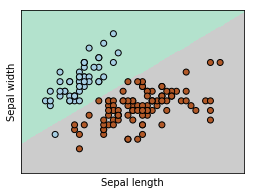

In [77]:
iris = datasets.load_iris()
X = iris.data[:, :2] # use only the first two features
Y = iris.target
n_samples = iris.data.shape[0]
Y[Y == 2] = 1 # change to a 2-class problem


def show_label_partition(Y):
    print("There are totally {} samples.".format(len(Y)))
    print("+:", np.sum(Y==1))
    print("-:", np.sum(Y==0))

def fit_plot(X, Y, fit_classifier=None):
    h = .02 # mesh step size
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    if fit_classifier:
        # we create an instance of Neighbours Classifier and fit the data.
        fit_classifier.fit(X, Y)
        Z = fit_classifier.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure(1, figsize=(4, 3))
        plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
    
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()

show_label_partition(Y)
fit_plot(X, Y, fit_classifier=SoftmaxRegression(l2=1e-5, epochs=100))

### Transferring to PU

 - sample 50% of +, the left becomes P
 - flip sampled + to -
 - join flipped + with - as U

In [78]:
np.random.seed(42)
flip = np.random.rand(n_samples)
Y_pu = Y.copy()
Y_pu[(Y == 1) & (flip < 0.5)] = 0
show_label_partition(Y_pu)

There are totally 150 samples.
+: 48
-: 102


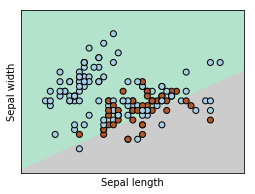

Loss: 0.253654254981


In [110]:
np.random.seed(None)
softreg = SoftmaxRegression(eta=5e-4, l2=1e-5,
                            epochs=200,
                            random_seed=None)
fit_plot(X, Y_pu, fit_classifier=softreg)
print("Loss:", softreg.cost_[-1])

### Asymmetric Softmax Loss

In [81]:
class AsymmetricSoftmaxRegression(SoftmaxRegression):
    def __init__(self, betas, eta=0.01, epochs=100,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):
        super(AsymmetricSoftmaxRegression, self).__init__(eta, epochs,
                                                         l2, minibatches,
                                                         n_classes,
                                                         random_seed)
        self._betas = np.array(betas)

    def _cost(self, prob, y_enc):
        cross_entropy = self._cross_entropy(prob, y_enc)
        betas = self._get_betas(y_enc)
        loss = betas * cross_entropy
        loss = np.sum(loss, axis=1)
        L2_term = self.l2 * np.sum(self.w_ ** 2)
        loss = loss + L2_term
        return 0.5 * np.mean(loss)
    
    def _diff(self, softm, y_enc):
        betas = self._get_betas(y_enc)
        return betas * (softm - y_enc)

    def _get_betas(self, y_enc):
        r"""Return betas per sample \beta_t of shape (N, C)."""
        label = np.argmax(y_enc, axis=1).astype('int8')
        label = label[:, np.newaxis]
        betas = self._betas[label]
        repeats = [1] * len(label.shape)
        repeats[1] = self.n_classes
        return np.tile(betas, repeats)

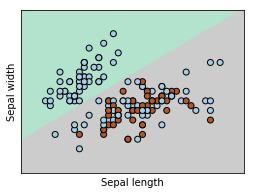

Loss: 0.106439949478


In [124]:
np.random.seed(None)
asym_softreg = AsymmetricSoftmaxRegression(betas=(0.2, 1),
                                           eta=1e-3, l2=1e-5,
                                           epochs=200,
                                           random_seed=None)
fit_plot(X, Y_pu, fit_classifier=asym_softreg)
print('Loss:', asym_softreg.cost_[-1])

### HardBootstrapping

In [50]:
class HardBootstrappingSoftmaxRegression(SoftmaxRegression):
    def __init__(self, betas, eta=0.01, epochs=100,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):
        super(HardBootstrappingSoftmaxRegression, self).__init__(eta, epochs,
                                                                 l2, minibatches,
                                                                 n_classes,
                                                                 random_seed)
        self._betas = np.array(betas)
        self._betas = self._betas / float(np.max(self._betas))

    def _cost(self, prob, y_enc):
        cross_ent_y = self._cross_entropy(prob, y_enc)
        pred = np.argmax(prob, axis=1)
        pred_enc = self._one_hot(y=pred, n_labels=self.n_classes, dtype=np.int)
        cross_ent_pred = self._cross_entropy(prob, pred_enc)
        betas = self._get_betas(y_enc)
        loss = betas * cross_ent_y + (1 - betas) * cross_ent_pred
        loss = np.sum(loss, axis=1)
        L2_term = self.l2 * np.sum(self.w_ ** 2)
        loss = loss + L2_term
        return 0.5 * np.mean(loss)
    
    def _diff(self, prob, y_enc):
        pred = np.argmax(prob, axis=1)
        pred_enc = self._one_hot(y=pred, n_labels=self.n_classes, dtype=np.int)
        betas = self._get_betas(y_enc)
        return betas * (prob - y_enc) + (1 - betas) * (prob - pred_enc)

    def _get_betas(self, y_enc):
        r"""Return betas per sample \beta_t of shape (N, C)."""
        label = np.argmax(y_enc, axis=1).astype('int8')
        label = label[:, np.newaxis]
        betas = self._betas[label]
        repeats = [1] * len(label.shape)
        repeats[1] = self.n_classes
        return np.tile(betas, repeats)

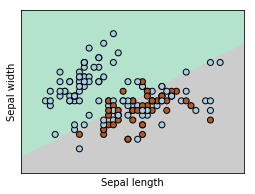

Loss 0.218677363134


In [181]:
np.random.seed(None)
hardb_softreg = HardBootstrappingSoftmaxRegression(betas=(0.5, 1),
                                                   eta=1e-3, l2=1e-5,
                                                   epochs=200,
                                                   random_seed=None)
fit_plot(X, Y_pu, fit_classifier=hardb_softreg)
print("Loss", hardb_softreg.cost_[-1])

## Gaussian distribution

In [285]:
def get_gaussians(n_samples, pct_positives=0.2, random_seed=None):
    np.random.seed(random_seed)
    n_positives = int(n_samples * pct_positives)
    n_negatives = int(n_samples * (1 - pct_positives))
    C = np.array([[.5, 0.], [0., 0.5]])
    X = np.r_[2. * np.random.randn(n_negatives, 2) + np.array([-5, 2]),
         np.dot(np.random.randn(n_positives, 2), C)]
    Y = np.r_[np.zeros(n_negatives), np.ones(n_positives)].astype('int')
    return X, Y

def get_PU_labels(Y, betas, random_seed=None):
    # To PU
    Y_pus = []
    np.random.seed(random_seed)
    for beta in betas:
        Y_pu = Y.copy()
        flip = np.random.rand(n_samples)
        Y_pu[(Y == 1) & (flip < beta)] = 0
        Y_pus.append((beta, Y_pu))
        if random_seed is not None:
            print('Positive (beta={}):'.format(beta),
                  np.sum(Y), ' vs.', np.sum(Y_pu))
    return Y_pus

# Number of samples per component
n_samples = 500

# Percentage of test samples
pct_positives = 0.2

# Generate random sample, two components
random_seed = 0
                       
X, Y = get_gaussians(n_samples, pct_positives, random_seed)
betas = np.arange(0., 1+1e-8, 0.1)
Y_pus = get_PU_labels(Y, betas, random_seed)

Positive (beta=0.0): 100  vs. 100
Positive (beta=0.1): 100  vs. 90
Positive (beta=0.2): 100  vs. 79
Positive (beta=0.30000000000000004): 100  vs. 67
Positive (beta=0.4): 100  vs. 62
Positive (beta=0.5): 100  vs. 47
Positive (beta=0.6000000000000001): 100  vs. 35
Positive (beta=0.7000000000000001): 100  vs. 19
Positive (beta=0.8): 100  vs. 17
Positive (beta=0.9): 100  vs. 10
Positive (beta=1.0): 100  vs. 0


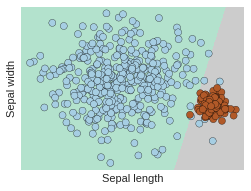

Loss 0.0298310907887


In [277]:
np.random.seed(None)
softreg = SoftmaxRegression(eta=1e-3, l2=1e-5,
                            epochs=100,
                            random_seed=12)
fit_plot(X, Y, fit_classifier=softreg)
print("Loss", softreg.cost_[-1])

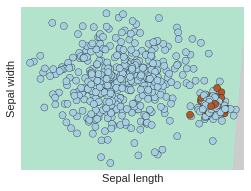

Loss 0.0540303839678


In [278]:
np.random.seed(None)
softreg = SoftmaxRegression(eta=1e-3, l2=1e-5,
                            epochs=100,
                            random_seed=12)
fit_plot(X, Y_pus[7][1], fit_classifier=softreg)
print("Loss", softreg.cost_[-1])

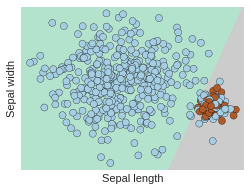

Loss: 0.0326066461596


In [279]:
np.random.seed(None)
asym_softreg = AsymmetricSoftmaxRegression(betas=(0.2, 1),
                                           eta=1e-3, l2=1e-5,
                                           epochs=100,
                                           random_seed=None)
fit_plot(X,  Y_pus[5][1], fit_classifier=asym_softreg)
print('Loss:', asym_softreg.cost_[-1])

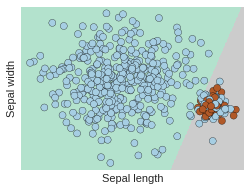

Loss 0.046579293246


In [280]:
np.random.seed(None)
hardb_softreg = HardBootstrappingSoftmaxRegression(betas=(0.2, 1),
                                                   eta=1e-3, l2=1e-5,
                                                   epochs=100,
                                                   random_seed=None)
fit_plot(X, Y_pus[5][1], fit_classifier=hardb_softreg)
print("Loss", hardb_softreg.cost_[-1])

### Asymmetry

In [288]:
import pandas as pd
from sklearn import metrics


np.random.seed(42)
X_test = np.r_[2. * np.random.randn(n_samples-100, 2) + np.array([-5, 2]),
         np.dot(np.random.randn(100, 2), C)]
Y_test = np.r_[np.zeros(n_samples-100), np.ones(100)].astype('int')
np.random.seed(None)

classifiers = {
    'softreg': SoftmaxRegression(eta=1e-3, l2=1e-5,
                      epochs=100,
                      random_seed=None),
    'asym_softreg': AsymmetricSoftmaxRegression(betas=(0.2, 1),
                                eta=1e-3, l2=1e-5,
                                epochs=100,
                                random_seed=None),
    'hardb_softreg': HardBootstrappingSoftmaxRegression(betas=(0.2, 1),
                                       eta=1e-3, l2=1e-5,
                                       epochs=100,
                                       random_seed=None)
}

acc_grid = pd.DataFrame(columns=['%missing', 'softreg',
                                 'asym_softreg', 'hardb_softreg'])
n_iters = 20
for it in range(n_iters):
    X, Y = get_gaussians(n_samples=500, pct_positives=0.2, random_seed=None)
    Y_pus = get_PU_labels(Y, betas=np.arange(0., 1+1e-8, 0.1), random_seed=None)
    for idx in range(len(Y_pus)):
        acc_grid.loc[it*len(Y_pus)+idx, '%missing'] = Y_pus[idx][0]
        for name, clsf in classifiers.items():
            clsf.fit(X, Y_pus[idx][1])
            Y_pred = clsf.predict(X_test)
            auc = metrics.roc_auc_score(Y, Y_pred)
            acc_grid.loc[it*len(Y_pus)+idx, name] = auc

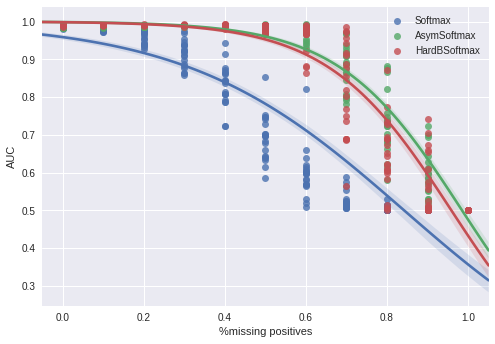

In [317]:
import seaborn as sns
f, ax = plt.subplots(1)
acc_grid[acc_grid.columns] = acc_grid[acc_grid.columns].apply(pd.to_numeric)
sns.regplot(x='%missing', y='softreg', data=acc_grid, logistic=True, label='Softmax', ax=ax)
sns.regplot(x='%missing', y='asym_softreg', data=acc_grid, logistic=True, label='AsymSoftmax', ax=ax)
sns.regplot(x='%missing', y='hardb_softreg', data=acc_grid, logistic=True, label='HardBSoftmax', ax=ax)
ax.set_xlabel('%missing positives')
ax.set_ylabel('AUC')
ax.legend()